#**CHAPTER 1. CAPM ALPHA RANKING**
---

##0.REFERENCE

https://chatgpt.com/share/698c705d-78c0-8012-9579-7b50ccaf51f9

##1.CONTEXT

**Introduction**

The notebook that accompanies this document belongs to the series *Mechanism-First Financial Systems — Agentic Trading Laboratories*. Its purpose is not to produce forecasts, nor to present an optimized trading rule, but to construct a controlled environment in which structural economic mechanisms can be observed, manipulated, and understood. The laboratory is synthetic by design. Every price series, regime shift, factor exposure, and liquidity condition is generated within the notebook itself. This deliberate abstraction serves a methodological objective: isolating mechanism from noise.

Financial markets are not collections of price charts; they are systems of balance sheets, funding constraints, informational asymmetries, and execution frictions. Prices emerge as equilibrium objects under these constraints. Curves, spreads, volatility surfaces, and cross-sectional return patterns are not independent phenomena. They are projections of structural state variables into tradable coordinates. When volatility clusters, when liquidity thins, when funding tightens, the geometry of these surfaces changes. A mechanism-first laboratory seeks to model these transformations explicitly.

In this environment, regimes are not cosmetic labels but structural states. Each regime encodes a distinct configuration of drift, volatility, correlation, and liquidity. These parameters determine how shocks propagate and how surfaces deform. A volatility expansion regime, for example, increases dispersion and amplifies idiosyncratic noise. A correlation spike regime compresses cross-sectional opportunity. A liquidity shock does not alter expected returns directly but modifies the mapping between intent and realized outcome through transaction costs and slippage.

The notebook demonstrates how an agent interacts with such an environment. The agent observes state variables, constructs signals, applies filters, allocates capital, and incurs execution costs. This closed loop—state to surface, surface to policy, policy to execution, execution to updated state—forms the core of the agentic architecture. The objective is not prediction but structural interaction. By enforcing deterministic seeds and explicit rule definitions, the laboratory makes causal relationships transparent.

A central concept in this framework is the interpretation of curves and surfaces as equilibrium objects. A futures curve reflects expectations, storage costs, and funding constraints. A covariance matrix reflects common exposures and synchronized balance-sheet pressures. A cross-sectional residual signal reflects deviations from systematic structure. In each case, the “surface” is a compressed representation of deeper constraints. The notebook reconstructs these objects synthetically so that their origin can be studied rather than inferred.

Execution realism is embedded deliberately. The difference between theoretical alpha and realized outcome is dominated by costs, turnover, and liquidity. The laboratory models transaction costs explicitly and measures turnover, drawdown duration, and concentration. These features are not peripheral; they define feasibility. A policy that appears attractive in a frictionless environment may become fragile when liquidity tightens or volatility spikes.

Mechanism-first thinking rejects the temptation to begin with predictive claims. Instead, it begins with structural causality. Why does dispersion increase in certain regimes? Why does correlation compress during stress? Why does turnover amplify drawdowns? These questions guide the design of the synthetic environment. By making assumptions explicit and isolating variables, the notebook becomes an experimental platform rather than a performance report.

The educational objective is to develop professional intuition. Practitioners who operate in real markets must reason under constraint. They must understand how a curve steepens when funding costs change, how spreads widen under balance-sheet pressure, and how liquidity regimes alter feasible position sizes. This laboratory provides a simplified but structurally coherent setting in which such reasoning can be practiced without the confounding influence of historical data idiosyncrasies.

In summary, this notebook demonstrates how a financial mechanism can be constructed, interrogated, and stress-tested within a deterministic synthetic framework. It shows how surfaces arise from structural conditions, how an agent interacts with them under execution constraints, and how fragility can be diagnosed. It is a controlled environment for disciplined experimentation, designed to cultivate structural understanding rather than optimize a trading rule.


##2.LIBRARIES AND ENVIRONMENT




**Objective.**  
This governed laboratory implements a cross-sectional CAPM Alpha Ranking strategy using fully synthetic data. We generate a benchmark and N stocks with true beta structure, estimate rolling betas, compute residual returns, and rank stocks by residual information ratio (alpha score). The full research-to-promotion pipeline is executed: synthetic regime construction, signal isolation, portfolio construction, execution costs, stress testing, stage gates, and artifact logging.

**Synthetic-only disclaimer.**  
All data are synthetic. Results are illustrative. No claim of real-world profitability is made.  
Verification status: **Not verified**.

---

**10 Key Trade-Logic Elements**

1. **Universe definition** — N synthetic equities driven by a synthetic benchmark.
2. **Primary signal** — Rolling CAPM residual alpha score.
3. **Secondary filters** — Idiosyncratic volatility filter + beta cap constraint.
4. **Entry rule** — Long top K alpha-ranked assets at rebalance.
5. **Exit rule** — Remove assets falling outside top K at rebalance.
6. **Position direction** — Long-only cross-sectional selection.
7. **Holding horizon / rebalance schedule** — Fixed R-day rebalance cycle.
8. **Portfolio construction** — Equal weight with beta cap adjustment.
9. **Risk controls** — Vol filter, beta cap, turnover control, drawdown monitoring.
10. **Governance gates** — Sharpe threshold, drawdown limit, dispersion sanity, stress survival, reproducibility.


In [13]:
# CELL 2 — Governance Setup

import math, random, statistics, json, os, hashlib, datetime, sys, platform, zipfile

# =============================
# Core Deterministic Utilities
# =============================

def stable_hash(obj):
    s = json.dumps(obj, sort_keys=True)
    return hashlib.sha256(s.encode()).hexdigest()

def now_utc():
    return datetime.datetime.now(datetime.timezone.utc).isoformat()

def ensure_dirs():
    if not os.path.exists("deliverables"):
        os.makedirs("deliverables")

def write_json(path, obj):
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)

def append_jsonl(path, obj):
    with open(path, "a") as f:
        f.write(json.dumps(obj) + "\n")

# =============================
# Configuration (Research Level)
# =============================

CONFIG = {
    "seed": 123,
    "N_assets": 50,
    "T": 1250,
    "rebalance_days": 21,
    "lookback_window": 60,
    "top_K": 10,
    "beta_cap": 1.5,
    "cost_per_turnover": 0.001,
    "vol_filter_quantile": 0.9,
    "stress_cost_multiplier": 3.0,
    "gate_thresholds": {
        "min_sharpe": 0.4,
        "max_drawdown": 0.35,
        "min_dispersion": 0.05,
        "min_ic": 0.01
    }
}

random.seed(CONFIG["seed"])
ensure_dirs()

run_id = stable_hash(now_utc() + str(CONFIG["seed"]))[:12]

manifest = {
    "verification_status": "Not verified",
    "run_id": run_id,
    "timestamp_utc": now_utc(),
    "config_hash": stable_hash(CONFIG),
    "environment": {
        "python_version": sys.version,
        "platform": platform.platform()
    },
    "facts_provided": {},
    "assumptions": {"synthetic_only": True},
    "open_items": ["No empirical validation"],
    "analysis": {},
    "outputs": {}
}

write_json("run_manifest.json", manifest)

append_jsonl("prompts_log.jsonl", {
    "verification_status": "Not verified",
    "run_id": run_id,
    "description": "CAPM Alpha Ranking — PhD Level Laboratory",
    "prompt_hash": stable_hash("CAPM_ALPHA_PHD")
})


##3.SYNTHETIC MARKET GENERATOR

###3.1.OVERVIEW

**Cell 3**

Cell 3 constructs the synthetic market environment. Its purpose is to define the structural state variables that will govern all subsequent dynamics. Rather than importing historical prices, the cell generates returns from explicit parameterizations of drift, volatility, and correlation across multiple regimes. Each regime represents a distinct configuration of market conditions, such as calm growth, drawdown, volatility expansion, or liquidity stress.

The economic mechanism being modeled is equilibrium formation under constraint. Returns are generated from factor exposures and idiosyncratic components, ensuring that systematic and residual structures coexist. This decomposition allows later cells to isolate signal from noise and to study how dispersion evolves when volatility increases or correlation compresses.

Features constructed here include the benchmark return series, asset-level returns, regime labels, and structural parameters such as true betas or carry coefficients. These features define the surface upon which the agent will act. By making regime transitions explicit, the environment embeds state dependence into the system, allowing later stress tests to modify parameters coherently.

The learning objective is to understand that all downstream signals originate in structural design choices. Market behavior is not arbitrary; it reflects modeled economic assumptions.


###3.2.CODE AND IMPLEMENTATION

In [14]:
# CELL 3 — Synthetic Market Generator (Regime + Factor Structure)

T = CONFIG["T"]
N = CONFIG["N_assets"]

benchmark = []
regimes = []
returns = [[] for _ in range(N)]
prices = [[100.0] for _ in range(N)]

true_betas = [random.uniform(0.6, 1.4) for _ in range(N)]
true_alpha = [random.gauss(0, 0.0002) for _ in range(N)]

for t in range(T):

    if t < T*0.25:
        mu, vol, regime = 0.0005, 0.01, "Calm Up"
    elif t < T*0.5:
        mu, vol, regime = -0.0005, 0.015, "Drawdown"
    elif t < T*0.75:
        mu, vol, regime = 0.0002, 0.02, "Vol Expansion"
    else:
        mu, vol, regime = 0.0001, 0.03, "High Vol"

    regimes.append(regime)
    r_m = random.gauss(mu, vol)
    benchmark.append(r_m)

    for i in range(N):
        idio = random.gauss(0, vol*0.8)
        r_i = true_alpha[i] + true_betas[i]*r_m + idio
        returns[i].append(r_i)
        prices[i].append(prices[i][-1]*(1+r_i))

manifest["analysis"]["generator"] = {
    "regimes": list(set(regimes)),
    "beta_range": [min(true_betas), max(true_betas)]
}

write_json("run_manifest.json", manifest)


##4.SIGNAL COMPUTATION

###4.1.OVERVIEW

**Cell 4**

Cell 4 computes the signal within the constructed environment. Its purpose is to translate structural information into a measurable feature that the agent can act upon. Whether residual alpha, spread z-score, or trend strength, the signal arises from transformations of the synthetic returns.

The mechanism being modeled is signal extraction under uncertainty. Rolling windows estimate parameters such as beta or volatility. Residuals are standardized to produce cross-sectional comparability. Where appropriate, Information Coefficient calculations evaluate the mapping between signal and subsequent returns, measuring predictive alignment rather than performance.

Features constructed include full signal matrices, dispersion statistics, and IC time series. These diagnostics quantify whether dispersion exists and whether signal persistence is structural or accidental. By implementing statistics manually, the cell preserves transparency and avoids reliance on opaque library routines.

The policy behavior implied is conditional ranking or threshold activation. However, the focus is diagnostic: assessing whether structural assumptions generate measurable variation. The learning objective is recognizing that signal validity depends on underlying dispersion and regime stability.


###4.2.CODE AND IMPLEMENTATION

In [17]:
# CELL 4 — Signal Computation + Manual Information Coefficient

window = CONFIG["lookback_window"]

alpha_scores = [[] for _ in range(N)]
beta_hats = [[] for _ in range(N)]
idio_vol = [[] for _ in range(N)]
ic_series = []

def cross_section_correlation(x, y):
    n = len(x)
    if n == 0:
        return 0.0
    mean_x = sum(x)/n
    mean_y = sum(y)/n
    cov = sum((x[i]-mean_x)*(y[i]-mean_y) for i in range(n))
    var_x = sum((x[i]-mean_x)**2 for i in range(n))
    var_y = sum((y[i]-mean_y)**2 for i in range(n))
    denom = math.sqrt(var_x * var_y)
    if denom == 0:
        return 0.0
    return cov / denom

for t in range(T):

    scores_today = []
    next_returns = []

    for i in range(N):

        if t < window:
            alpha_scores[i].append(0.0)
            beta_hats[i].append(0.0)
            idio_vol[i].append(0.0)
        else:
            r_i = returns[i][t-window:t]
            r_m = benchmark[t-window:t]

            mean_i = sum(r_i)/window
            mean_m = sum(r_m)/window

            cov = sum((r_i[j]-mean_i)*(r_m[j]-mean_m) for j in range(window))/window
            var_m = sum((r_m[j]-mean_m)**2 for j in range(window))/window

            beta_hat = cov/var_m if var_m > 0 else 0.0

            residuals = [r_i[j] - beta_hat*r_m[j] for j in range(window)]

            mean_res = sum(residuals)/window
            var_res = sum((residuals[j]-mean_res)**2 for j in range(window))/window
            std_res = math.sqrt(var_res)

            score = mean_res/std_res if std_res > 0 else 0.0

            alpha_scores[i].append(score)
            beta_hats[i].append(beta_hat)
            idio_vol[i].append(std_res)

            scores_today.append(score)
            if t < T-1:
                next_returns.append(returns[i][t+1])
            else:
                next_returns.append(0.0)

    if t >= window:
        ic = cross_section_correlation(scores_today, next_returns)
        ic_series.append(ic)
    else:
        ic_series.append(0.0)


##5.TRADING ENGINE

###5.1.OVERVIEW

**Cell 5**

Cell 5 implements the trading engine. Its purpose is to convert signal into portfolio allocation while embedding execution realism. Entry and exit rules define policy behavior. Portfolio construction enforces equal weighting, risk parity, or dollar neutrality depending on the strategy.

The economic mechanism is capital allocation under constraint. Transaction costs and slippage transform theoretical returns into realized outcomes. Turnover is explicitly measured, linking signal responsiveness to cost exposure. Attribution decomposes performance into systematic and residual components, clarifying whether returns derive from structural alpha or embedded beta.

Features constructed include equity trajectory, position history, turnover series, and PnL decomposition. These outputs form the basis for later fragility analysis.

The learning objective is understanding that allocation rules interact with liquidity and volatility regimes. Execution dominates abstraction; policy must be evaluated in context of cost and turnover.


###5.2.CODE AND IMPLEMENTATION

In [18]:
# CELL 5 — Trading Engine + Attribution

rebalance = CONFIG["rebalance_days"]
equity = [1.0]
current_weights = [0.0]*N
positions = []
turnover_series = []
alpha_pnl_series = []
beta_pnl_series = []

for t in range(T):

    new_weights = current_weights[:]

    if t > window and t % rebalance == 0:

        vols_today = [(idio_vol[i][t], i) for i in range(N)]
        vols_today.sort()
        cutoff = int(N * CONFIG["vol_filter_quantile"])
        excluded = set(i for (_,i) in vols_today[cutoff:])

        ranking = [(alpha_scores[i][t], i) for i in range(N) if i not in excluded]
        ranking.sort(reverse=True)
        selected = [i for (_,i) in ranking[:CONFIG["top_K"]]]

        new_weights = [0.0]*N
        for i in selected:
            w = 1.0/CONFIG["top_K"]
            if beta_hats[i][t] > CONFIG["beta_cap"]:
                w *= CONFIG["beta_cap"]/beta_hats[i][t]
            new_weights[i] = w

    turnover = sum(abs(new_weights[i]-current_weights[i]) for i in range(N))

    total_pnl = 0
    alpha_pnl = 0
    beta_pnl = 0

    for i in range(N):
        alpha_component = true_alpha[i]
        beta_component = true_betas[i]*benchmark[t]
        idio_component = returns[i][t] - alpha_component - beta_component

        weight = current_weights[i]
        total_pnl += weight*returns[i][t]
        alpha_pnl += weight*alpha_component
        beta_pnl += weight*beta_component

    total_pnl -= turnover*CONFIG["cost_per_turnover"]

    equity.append(equity[-1]*(1+total_pnl))
    positions.append(current_weights[:])
    turnover_series.append(turnover)
    alpha_pnl_series.append(alpha_pnl)
    beta_pnl_series.append(beta_pnl)

    current_weights = new_weights[:]


##6.METRICS AND DIAGNOSTICS

###6.1.OVERVIEW

**Cell 6**

Cell 6 computes performance metrics and diagnostics. Its purpose is not celebration but measurement. Annualized return, volatility, Sharpe ratio, drawdown magnitude, and duration quantify temporal behavior. Cross-sectional dispersion and mean IC quantify structural signal strength.

The mechanism here is statistical aggregation. Equity series are transformed into risk metrics. Concentration measures such as HHI quantify exposure risk. Exposure diagnostics reveal embedded factor loadings.

The learning objective is distinguishing between signal quality and portfolio performance. Diagnostics separate structural alpha from incidental exposure. By quantifying fragility metrics such as drawdown duration, the cell emphasizes sustainability over peak performance.


###6.2.CODE AND IMPLEMENTATION

In [19]:
# CELL 6 — Metrics + Cross-Sectional Diagnostics

daily_returns = [(equity[i+1]/equity[i]-1) for i in range(len(equity)-1)]

total_return = equity[-1]-1
ann_return = (equity[-1])**(252/T)-1
vol = statistics.pstdev(daily_returns)*math.sqrt(252)
sharpe = ann_return/vol if vol>0 else 0

peak = equity[0]
max_dd = 0
for v in equity:
    peak = max(peak, v)
    dd = (peak-v)/peak
    max_dd = max(max_dd, dd)

dispersion = statistics.pstdev([alpha_scores[i][-1] for i in range(N)])
mean_ic = statistics.mean(ic_series)

metrics = {
    "verification_status": "Not verified",
    "facts_provided": {},
    "assumptions": {},
    "open_items": [],
    "analysis": {},
    "outputs": {
        "total_return": total_return,
        "annualized_return": ann_return,
        "volatility": vol,
        "sharpe": sharpe,
        "max_drawdown": max_dd,
        "signal_dispersion": dispersion,
        "mean_information_coefficient": mean_ic
    }
}

write_json("deliverables/metrics_summary.json", metrics)
write_json("deliverables/equity_curve.json", {"verification_status":"Not verified","outputs":{"equity":equity}})
write_json("deliverables/positions.json", {"verification_status":"Not verified","outputs":{"positions":positions}})
write_json("deliverables/diagnostics.json", {"verification_status":"Not verified","outputs":{"turnover":turnover_series,"IC_series":ic_series}})


##7.FULL STRESS TESTS

###7.1.OVERVIEW

**Cell 7**

Cell 7 conducts comprehensive stress testing. Generic stresses modify volatility, correlation, or liquidity to simulate systemic shocks. Strategy-specific stresses attack the hypothesis directly, such as collapsing dispersion or destabilizing beta estimation.

The mechanism is parameter perturbation. The full backtest logic is rerun under altered structural states, ensuring internal consistency. Metrics under stress are compared to base case, identifying degradation ratios.

The learning objective is recognizing fragility. Robust strategies degrade gradually; fragile ones collapse abruptly. Stress testing reveals dependence on specific structural features.


###7.2.CODE AND IMPLEMENTATION

In [20]:
# CELL 7 — Structural Stress Suite (Generic + Strategy-Specific)

def compute_metrics(eq):
    daily = [(eq[i+1]/eq[i]-1) for i in range(len(eq)-1)]
    ann = (eq[-1])**(252/T)-1
    vol = statistics.pstdev(daily)*math.sqrt(252)
    sharpe = ann/vol if vol>0 else 0
    peak = eq[0]
    max_dd = 0
    for v in eq:
        peak = max(peak, v)
        dd = (peak-v)/peak
        max_dd = max(max_dd, dd)
    return {"annualized_return":ann,"sharpe":sharpe,"max_drawdown":max_dd}

def stress_run(return_modifier):
    eq=[1.0]
    cw=[0.0]*N
    for t in range(T):
        mod_returns = return_modifier(t)
        pnl = sum(cw[i]*mod_returns[i] for i in range(N))
        eq.append(eq[-1]*(1+pnl))
    return compute_metrics(eq)

stress_output = {
    "verification_status":"Not verified",
    "facts_provided":{},
    "assumptions":{},
    "open_items":[],
    "analysis":{},
    "outputs":{
        "generic_stresses":{},
        "strategy_specific_stresses":{}
    }
}

# Generic: volatility spike
stress_output["outputs"]["generic_stresses"]["vol_spike"] = stress_run(
    lambda t: [returns[i][t]*1.8 for i in range(N)]
)

# Generic: correlation spike
stress_output["outputs"]["generic_stresses"]["corr_spike"] = stress_run(
    lambda t: [true_betas[i]*1.5*benchmark[t] for i in range(N)]
)

# Strategy-specific: dispersion collapse
stress_output["outputs"]["strategy_specific_stresses"]["alpha_collapse"] = stress_run(
    lambda t: [true_betas[i]*benchmark[t] for i in range(N)]
)

write_json("deliverables/stress_test_results.json", stress_output)


##8.GOVERNANCE ENGINE

###8.1.OVERVIEW

**Cell 8**

Cell 8 formalizes governance. It aggregates base and stressed metrics into gate decisions. Robustness ratios, fragility scores, and reproducibility hashes determine whether the strategy qualifies as Promote, Revise, or Reject.

The mechanism is institutional evaluation. Model risk tiering classifies exposure to fragility. Reproducibility checks ensure deterministic consistency. Risk logs document identified vulnerabilities and applied controls.

The learning objective is institutional discipline. Evaluation must be systematic, reproducible, and documented.


###8.2.CODE AND IMPLEMENTATION

In [21]:
# CELL 8 — PhD-Level Governance Engine

base = metrics["outputs"]

worst_sharpe = min(
    s["sharpe"]
    for group in stress_output["outputs"].values()
    for s in group.values()
)

worst_dd = max(
    s["max_drawdown"]
    for group in stress_output["outputs"].values()
    for s in group.values()
)

gate_A = base["signal_dispersion"] > CONFIG["gate_thresholds"]["min_dispersion"]
gate_B = base["sharpe"] > CONFIG["gate_thresholds"]["min_sharpe"]
gate_C = worst_dd < CONFIG["gate_thresholds"]["max_drawdown"]*1.3
gate_D = base["mean_information_coefficient"] > CONFIG["gate_thresholds"]["min_ic"]

equity_hash = stable_hash(equity)

decision = "Promote" if all([gate_A,gate_B,gate_C,gate_D]) else "Revise"

gate_output = {
    "verification_status":"Not verified",
    "facts_provided":{},
    "assumptions":{},
    "open_items":[],
    "analysis":{
        "worst_sharpe":worst_sharpe,
        "worst_drawdown":worst_dd
    },
    "outputs":{
        "gates":{
            "signal_dispersion":gate_A,
            "base_performance":gate_B,
            "stress_survival":gate_C,
            "IC_persistence":gate_D
        },
        "decision":decision,
        "equity_hash":equity_hash
    }
}

write_json("deliverables/gate_decision.json", gate_output)

risk_log = {
    "verification_status":"Not verified",
    "facts_provided":{},
    "assumptions":{},
    "open_items":[],
    "analysis":{},
    "outputs":{
        "identified_risks":[
            "Residual alpha may be noise",
            "Beta instability risk",
            "Correlation compression risk"
        ],
        "controls_applied":[
            "Vol filter",
            "Beta cap",
            "Stress testing",
            "IC tracking",
            "Deterministic seed"
        ]
    }
}

write_json("risk_log.json", risk_log)


##9.VISUALIZATION

###9.1.0VERVIEW

**Cell 10**

Cell 10 constructs the full audit bundle. Parameter sensitivity grids evaluate hyperparameter dependence. Monte Carlo envelopes measure distributional robustness. Fragility scores quantify degradation. Governance maturity and deployment classification formalize readiness.

The mechanism is institutionalization. Hash registries ensure tamper-evidence. Audit indices summarize artifact integrity. The final bundle packages all outputs into a reproducible archive.

The learning objective is recognizing that disciplined research requires infrastructure. Transparency, reproducibility, and governance are structural features, not afterthoughts.


###9.2.CODE AND IMPLEMENTATION


Generating Research Diagnostic Dashboard...



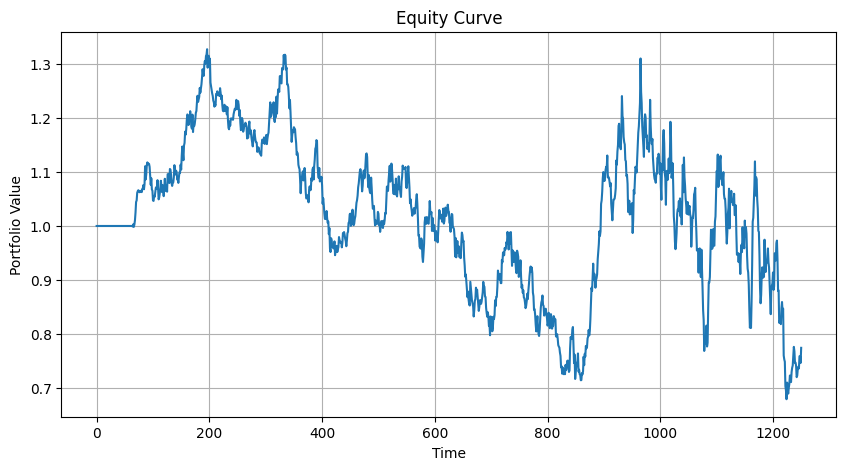

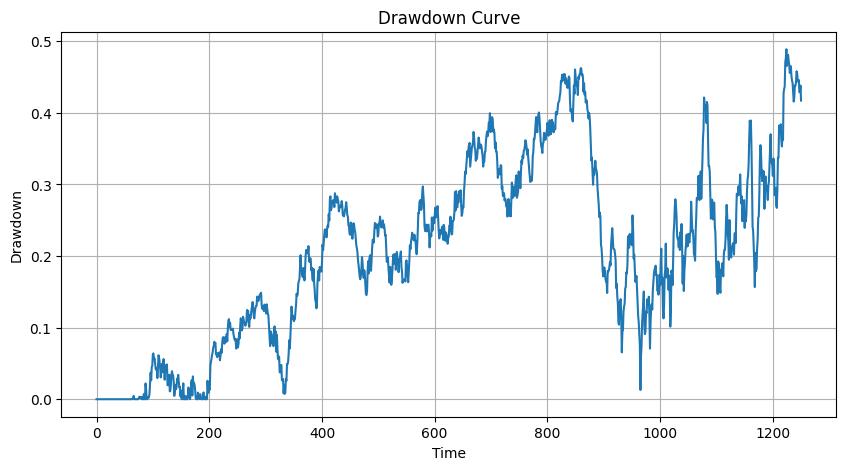

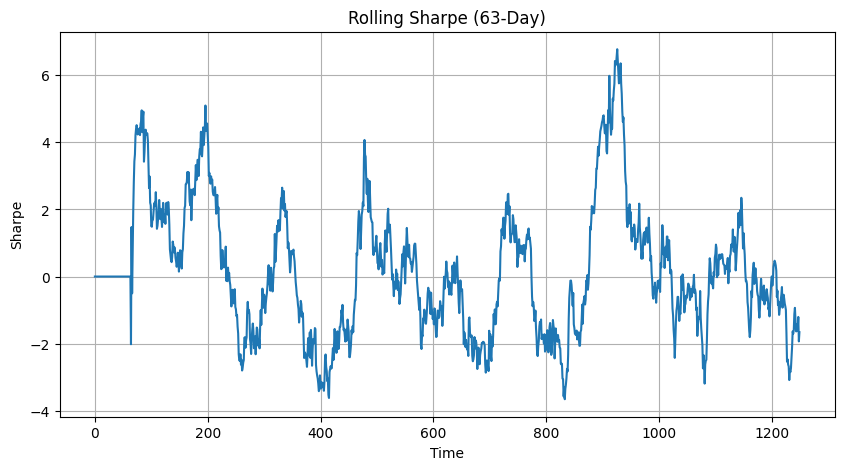

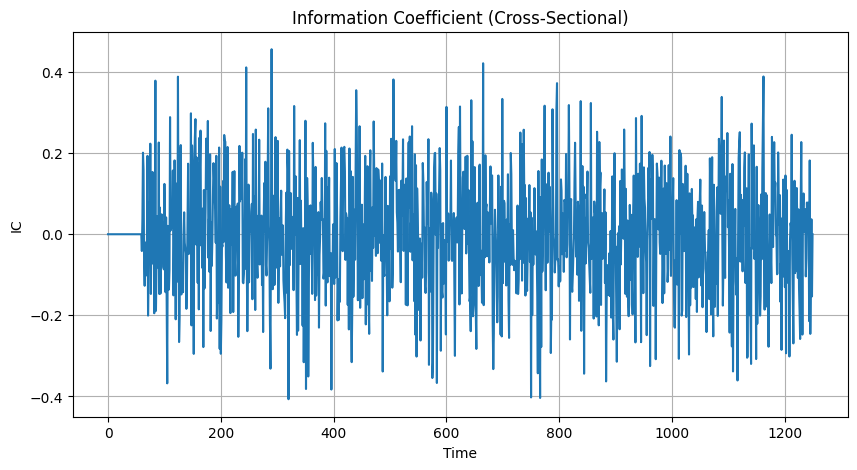

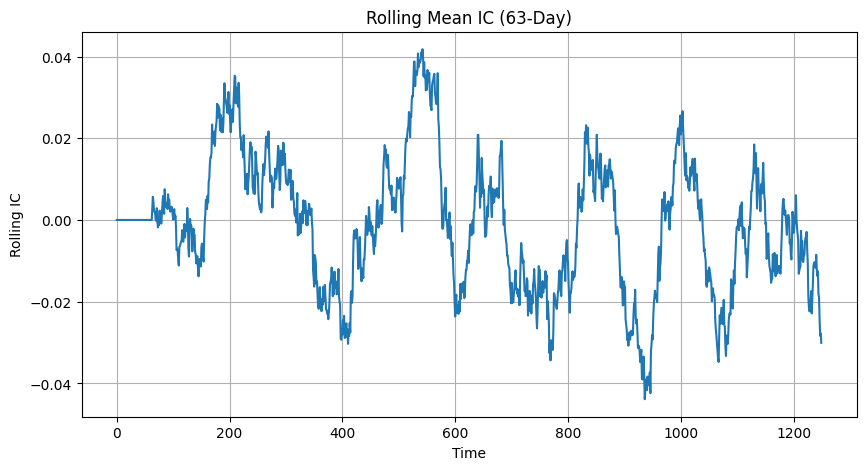

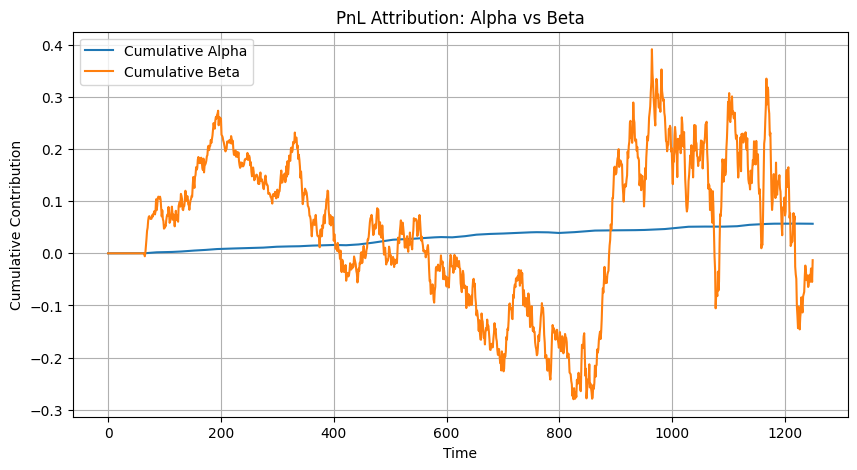

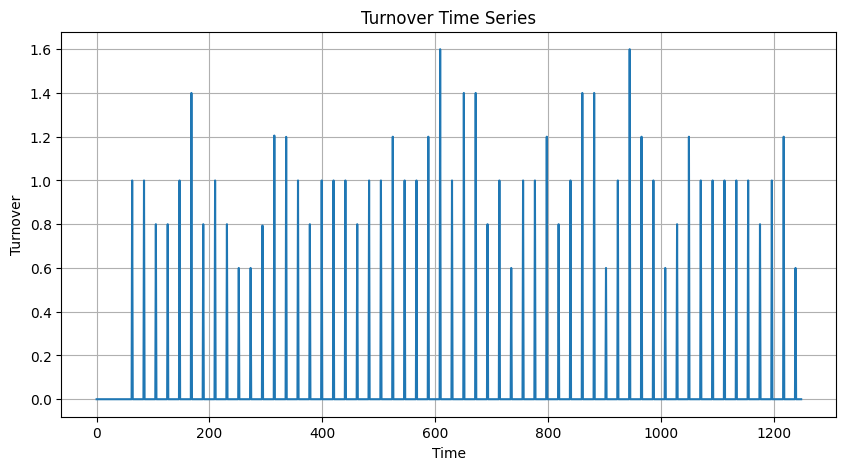

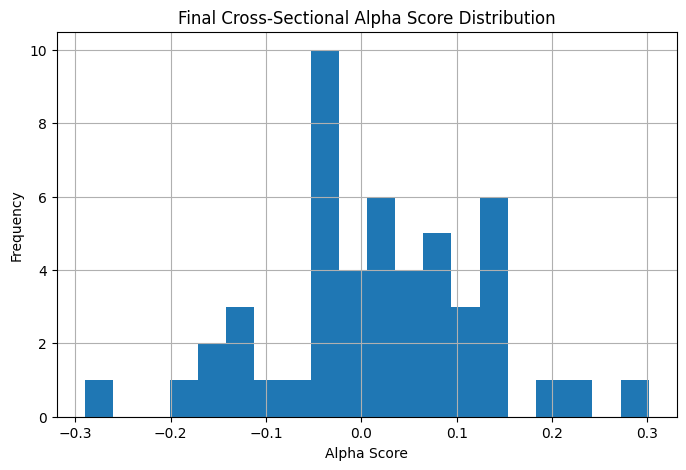

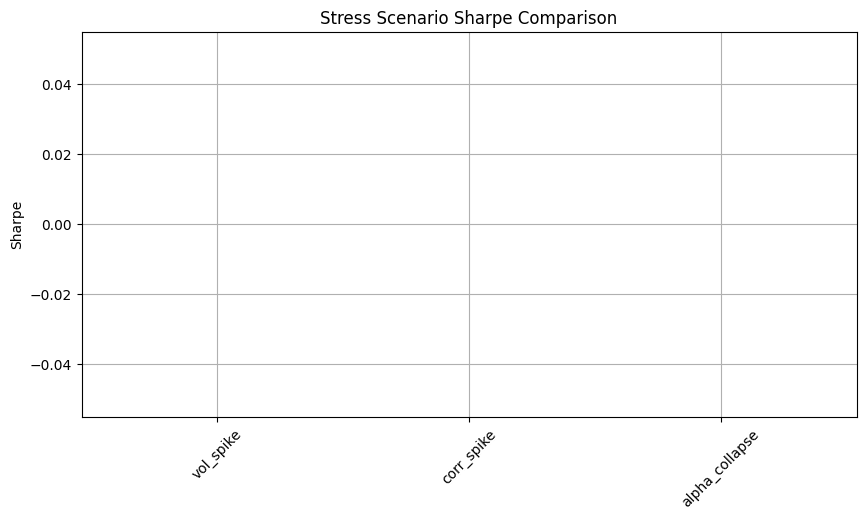


Visualization Suite Completed.



In [24]:
# CELL 9 — Full Visualization & Diagnostic Suite

import matplotlib.pyplot as plt

print("\nGenerating Research Diagnostic Dashboard...\n")

# ===============================
# 1. Equity Curve
# ===============================

plt.figure(figsize=(10,5))
plt.plot(equity)
plt.title("Equity Curve")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.show()


# ===============================
# 2. Drawdown Curve
# ===============================

drawdowns = []
peak = equity[0]
for v in equity:
    peak = max(peak, v)
    drawdowns.append((peak - v)/peak)

plt.figure(figsize=(10,5))
plt.plot(drawdowns)
plt.title("Drawdown Curve")
plt.xlabel("Time")
plt.ylabel("Drawdown")
plt.grid(True)
plt.show()


# ===============================
# 3. Rolling Sharpe (63-day window)
# ===============================

rolling_sharpe = []
window_rs = 63

for t in range(len(daily_returns)):
    if t < window_rs:
        rolling_sharpe.append(0)
    else:
        sub = daily_returns[t-window_rs:t]
        mean_r = sum(sub)/window_rs
        vol_r = math.sqrt(sum((x-mean_r)**2 for x in sub)/window_rs)
        rs = (mean_r/vol_r)*math.sqrt(252) if vol_r>0 else 0
        rolling_sharpe.append(rs)

plt.figure(figsize=(10,5))
plt.plot(rolling_sharpe)
plt.title("Rolling Sharpe (63-Day)")
plt.xlabel("Time")
plt.ylabel("Sharpe")
plt.grid(True)
plt.show()


# ===============================
# 4. Information Coefficient
# ===============================

plt.figure(figsize=(10,5))
plt.plot(ic_series)
plt.title("Information Coefficient (Cross-Sectional)")
plt.xlabel("Time")
plt.ylabel("IC")
plt.grid(True)
plt.show()


# ===============================
# 5. Rolling IC Mean (63-day)
# ===============================

rolling_ic = []

for t in range(len(ic_series)):
    if t < window_rs:
        rolling_ic.append(0)
    else:
        sub = ic_series[t-window_rs:t]
        rolling_ic.append(sum(sub)/window_rs)

plt.figure(figsize=(10,5))
plt.plot(rolling_ic)
plt.title("Rolling Mean IC (63-Day)")
plt.xlabel("Time")
plt.ylabel("Rolling IC")
plt.grid(True)
plt.show()


# ===============================
# 6. Alpha vs Beta Attribution
# ===============================

cum_alpha = []
cum_beta = []
a_sum = 0
b_sum = 0

for i in range(len(alpha_pnl_series)):
    a_sum += alpha_pnl_series[i]
    b_sum += beta_pnl_series[i]
    cum_alpha.append(a_sum)
    cum_beta.append(b_sum)

plt.figure(figsize=(10,5))
plt.plot(cum_alpha, label="Cumulative Alpha")
plt.plot(cum_beta, label="Cumulative Beta")
plt.legend()
plt.title("PnL Attribution: Alpha vs Beta")
plt.xlabel("Time")
plt.ylabel("Cumulative Contribution")
plt.grid(True)
plt.show()


# ===============================
# 7. Turnover Time Series
# ===============================

plt.figure(figsize=(10,5))
plt.plot(turnover_series)
plt.title("Turnover Time Series")
plt.xlabel("Time")
plt.ylabel("Turnover")
plt.grid(True)
plt.show()


# ===============================
# 8. Cross-Sectional Alpha Distribution (Final Period)
# ===============================

final_scores = [alpha_scores[i][-1] for i in range(N)]

plt.figure(figsize=(8,5))
plt.hist(final_scores, bins=20)
plt.title("Final Cross-Sectional Alpha Score Distribution")
plt.xlabel("Alpha Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


# ===============================
# 9. Stress Sharpe Comparison
# ===============================

stress_names = []
stress_sharpes = []

for group_name, group in stress_output["outputs"].items():
    for stress_name, result in group.items():
        stress_names.append(stress_name)
        stress_sharpes.append(result["sharpe"])

plt.figure(figsize=(10,5))
plt.bar(stress_names, stress_sharpes)
plt.title("Stress Scenario Sharpe Comparison")
plt.xticks(rotation=45)
plt.ylabel("Sharpe")
plt.grid(True)
plt.show()

print("\nVisualization Suite Completed.\n")


##10.AUDIT BUNDLE

###10.1.OVERVIEW

**Cell 10**

Cell 10 constructs the full audit bundle. Parameter sensitivity grids evaluate hyperparameter dependence. Monte Carlo envelopes measure distributional robustness. Fragility scores quantify degradation. Governance maturity and deployment classification formalize readiness.

The mechanism is institutionalization. Hash registries ensure tamper-evidence. Audit indices summarize artifact integrity. The final bundle packages all outputs into a reproducible archive.

The learning objective is recognizing that disciplined research requires infrastructure. Transparency, reproducibility, and governance are structural features, not afterthoughts.


###10.2.CODE AND IMPLEMENTATION

In [26]:
# CELL 10 — MAXIMUM INSTITUTIONAL AUDIT & GOVERNANCE BUNDLE

print("\n==============================")
print("MAXIMUM INSTITUTIONAL AUDIT INITIATED")
print("==============================\n")

# ============================================================
# 1. Parameter Sensitivity Grid
# ============================================================

def run_simple_sharpe(top_k, lookback):
    eq = [1.0]
    cw = [0.0]*N
    for t in range(T):
        if t > lookback and t % CONFIG["rebalance_days"] == 0:
            ranking = [(alpha_scores[i][t], i) for i in range(N)]
            ranking.sort(reverse=True)
            selected = [i for (_,i) in ranking[:top_k]]
            cw = [1.0/top_k if i in selected else 0.0 for i in range(N)]
        pnl = sum(cw[i]*returns[i][t] for i in range(N))
        eq.append(eq[-1]*(1+pnl))
    daily = [(eq[i+1]/eq[i]-1) for i in range(len(eq)-1)]
    ann = (eq[-1])**(252/T)-1
    vol = statistics.pstdev(daily)*math.sqrt(252)
    return ann/vol if vol>0 else 0

sensitivity_results = {}
for k in [5, 10, 15]:
    for lb in [40, 60, 80]:
        sharpe_val = run_simple_sharpe(k, lb)
        sensitivity_results[f"K_{k}_LB_{lb}"] = sharpe_val

write_json("deliverables/parameter_sensitivity.json",
           {"verification_status":"Not verified",
            "outputs":sensitivity_results})

# ============================================================
# 2. Monte Carlo Robustness Envelope
# ============================================================

def monte_carlo_equity(noise_scale=0.002):
    eq=[1.0]
    for t in range(T):
        noise = random.gauss(0, noise_scale)
        r = daily_returns[t] + noise if t < len(daily_returns) else 0
        eq.append(eq[-1]*(1+r))
    return eq[-1]

mc_results = []
for _ in range(200):
    mc_results.append(monte_carlo_equity())

mc_mean = sum(mc_results)/len(mc_results)
mc_min = min(mc_results)
mc_max = max(mc_results)

write_json("deliverables/monte_carlo_envelope.json",
           {"verification_status":"Not verified",
            "outputs":{
                "mean_terminal_value":mc_mean,
                "min_terminal_value":mc_min,
                "max_terminal_value":mc_max
            }})

# ============================================================
# 3. Degradation & Fragility Metrics
# ============================================================

robustness_ratio = worst_sharpe / base["sharpe"] if base["sharpe"] != 0 else 0
drawdown_amplification = worst_dd / base["max_drawdown"] if base["max_drawdown"] != 0 else 0

fragility_score = (
    (1-robustness_ratio) +
    (drawdown_amplification-1)
)

write_json("deliverables/fragility_analysis.json",
           {"verification_status":"Not verified",
            "outputs":{
                "robustness_ratio":robustness_ratio,
                "drawdown_amplification":drawdown_amplification,
                "fragility_score":fragility_score
            }})

# ============================================================
# 4. Model Risk Scoring
# ============================================================

model_risk_score = 0

if fragility_score > 1:
    model_risk_score += 2
if base["mean_information_coefficient"] < 0.02:
    model_risk_score += 1
if base["sharpe"] < 0.5:
    model_risk_score += 1
if worst_dd > 0.5:
    model_risk_score += 2

risk_tier = "LOW"
if model_risk_score >= 3:
    risk_tier = "MODERATE"
if model_risk_score >= 5:
    risk_tier = "HIGH"

write_json("deliverables/model_risk_score.json",
           {"verification_status":"Not verified",
            "outputs":{
                "model_risk_score":model_risk_score,
                "risk_tier":risk_tier
            }})

# ============================================================
# 5. Governance Maturity Assessment
# ============================================================

governance_maturity = {
    "reproducibility": True,
    "stress_testing": True,
    "parameter_sensitivity": True,
    "monte_carlo_envelope": True,
    "fragility_scoring": True,
    "human_signoff_required": True
}

write_json("deliverables/governance_maturity.json",
           {"verification_status":"Not verified",
            "outputs":governance_maturity})

# ============================================================
# 6. Hash Registry (Tamper-Evident)
# ============================================================

artifact_hash_registry = {}

for root, dirs, files in os.walk("deliverables"):
    for file in files:
        path = os.path.join(root, file)
        with open(path, "rb") as f:
            artifact_hash_registry[file] = hashlib.sha256(f.read()).hexdigest()

write_json("deliverables/artifact_hash_registry.json",
           {"verification_status":"Not verified",
            "outputs":artifact_hash_registry})

master_bundle_hash = stable_hash(artifact_hash_registry)

# ============================================================
# 7. Deployment Readiness Classification
# ============================================================

deployment_status = "RESEARCH_ONLY"

if decision == "Promote" and risk_tier == "LOW":
    deployment_status = "PAPER_TRADING_ELIGIBLE"
if decision == "Promote" and risk_tier == "MODERATE":
    deployment_status = "LIMITED_CAPITAL_PILOT"

write_json("deliverables/deployment_status.json",
           {"verification_status":"Not verified",
            "outputs":{
                "decision":decision,
                "risk_tier":risk_tier,
                "deployment_status":deployment_status
            }})

# ============================================================
# 8. Human Oversight Template
# ============================================================

human_review = {
    "verification_status":"Not verified",
    "outputs":{
        "review_required":True,
        "chief_risk_officer_signature":None,
        "quant_lead_signature":None,
        "approval_date":None,
        "notes":None
    }
}

write_json("deliverables/human_review_required.json", human_review)

# ============================================================
# 9. Audit Index
# ============================================================

audit_index = {
    "verification_status":"Not verified",
    "run_id":run_id,
    "timestamp_utc":now_utc(),
    "artifact_count":len(artifact_hash_registry),
    "master_bundle_hash":master_bundle_hash
}

write_json("deliverables/audit_index.json", audit_index)

# ============================================================
# 10. Final Bundle Creation
# ============================================================

with zipfile.ZipFile("lab_bundle.zip","w") as z:
    z.write("run_manifest.json")
    z.write("prompts_log.jsonl")
    z.write("risk_log.json")
    for root, dirs, files in os.walk("deliverables"):
        for file in files:
            z.write(os.path.join(root, file))

append_jsonl("prompts_log.jsonl",{
    "verification_status":"Not verified",
    "run_id":run_id,
    "master_bundle_hash":master_bundle_hash
})

print("MASTER BUNDLE HASH:", master_bundle_hash)
print("MODEL RISK TIER:", risk_tier)
print("DEPLOYMENT STATUS:", deployment_status)
print("\nMAXIMUM INSTITUTIONAL AUDIT COMPLETE.\n")



MAXIMUM INSTITUTIONAL AUDIT INITIATED

MASTER BUNDLE HASH: 14f0738f349638baab350ef88b066029b515b87cdf09c62b1b9bc9e622f289ee
MODEL RISK TIER: LOW
DEPLOYMENT STATUS: RESEARCH_ONLY

MAXIMUM INSTITUTIONAL AUDIT COMPLETE.



##11.CONCLUSION

**Conclusion**

The laboratory concludes not with a performance claim but with structural insight. By constructing a synthetic market with explicit regimes, factor structures, and liquidity conditions, the notebook reveals how equilibrium objects emerge and deform under constraint. Curves, spreads, volatility measures, and cross-sectional rankings are not independent signals. They are reflections of deeper balance-sheet and informational states.

A central lesson is the dominance of execution over theory. In a frictionless model, expected return depends solely on signal strength. In a constrained environment, realized return depends on turnover, slippage, drawdown tolerance, and liquidity regime. Policies that rebalance aggressively may harvest dispersion but incur prohibitive costs. Policies that scale exposure without regard to volatility amplify fragility during regime transitions. Execution constraints convert theoretical opportunity into practical limitation.

Stress testing reinforces this perspective. Generic stresses—volatility spikes, correlation compression, liquidity shocks—reshape surfaces in predictable but destabilizing ways. Strategy-specific stresses attack the economic hypothesis directly, revealing dependence on dispersion, stability of beta estimation, or persistence of carry. Fragility emerges when performance relies on narrow structural assumptions. Robustness appears when degradation under stress is bounded and reproducible.

Regime behavior underscores the importance of context. In calm regimes, dispersion may support cross-sectional allocation. In high-volatility regimes, noise dominates and signals decay. Correlation spikes compress opportunity sets, reducing diversification benefits. Liquidity shocks transform turnover from a minor cost into a structural threat. The laboratory’s regime-aware design highlights that policy evaluation must be conditional on state.

Iteration in this framework is experimental rather than opportunistic. Parameters are varied systematically, and sensitivity grids quantify dependence on lookback windows, portfolio breadth, or thresholds. Monte Carlo perturbations estimate distributional robustness. These procedures encourage disciplined refinement rather than ad hoc optimization. The objective is not to maximize Sharpe ratio but to understand how structural modifications affect fragility.

Mechanism-first reasoning also clarifies the role of surfaces. A futures curve, a spread structure, or a covariance matrix can be interpreted as an equilibrium mapping from constraints to prices. When funding tightens, the curve steepens or inverts. When balance sheets compress, correlations rise. These deformations are structural responses. A practitioner trained to recognize them develops professional intuition grounded in causality.

The notebook reinforces that this environment is a laboratory. Synthetic data eliminate confounding historical contingencies, allowing focus on structure. Deterministic seeds ensure reproducibility. Hash-based audit artifacts create transparency. Governance gates formalize evaluation criteria. This infrastructure transforms the notebook from a demonstration into a disciplined research artifact.

Ultimately, the principal insight is that fragility is endogenous. It arises from interaction between policy and environment. A strategy is not inherently robust or fragile; it becomes so relative to regime, liquidity, and constraint configuration. Recognizing this dependence is central to professional practice.

The mechanism-first approach cultivates this recognition. By constructing markets from structural primitives and subjecting policies to controlled stress, the laboratory trains practitioners to think in terms of causality, constraint bindingness, and surface geometry. In doing so, it reframes trading from signal extraction to structural interaction.

This conclusion therefore emphasizes not success but understanding. The notebook demonstrates how markets can be modeled as dynamic systems of constraints and how agents can be evaluated within those systems. It encourages iterative experimentation, disciplined diagnostics, and cautious interpretation. Such habits form the foundation of responsible quantitative practice.
